In [1]:
import collections
import os
import json

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
import statsmodels.api as sm
from sqlalchemy import create_engine

if os.getcwd().endswith('notebook'):
    os.chdir('..')

from rna_learn.alphabet import ALPHABET_DNA
from rna_learn.load_sequences import (
    load_growth_temperatures, 
    compute_inverse_probability_weights,
    assign_weight_to_batch_values,
)
from rna_learn.transform import sequence_embedding, normalize, denormalize
from rna_learn.model import conv1d_densenet_regression_model, compile_regression_model, DenormalizedMAE

In [2]:
sns.set(palette='colorblind', font_scale=1.3)

In [3]:
db_path = os.path.join(os.getcwd(), 'data/condensed_traits/db/seq.db')
engine = create_engine(f'sqlite+pysqlite:///{db_path}')

In [4]:
run_id = 'run_31tod'
model_path = os.path.join(os.getcwd(), f'saved_models/{run_id}/model.h5')
metadata_path = os.path.join(os.getcwd(), f'saved_models/{run_id}/metadata.json')

In [5]:
with open(metadata_path) as f:
    metadata = json.load(f)
    
metadata

{'run_id': 'run_31tod',
 'alphabet': ['A', 'C', 'G', 'T'],
 'learning_rate': 0.0001,
 'batch_size': 64,
 'encoding_size': 20,
 'decoder_n_hidden': 100,
 'growth_rate': 15,
 'n_layers': 5,
 'kernel_sizes': [2, 3, 5, 5, 10],
 'dilation_rates': [1, 1, 4, 1, 1],
 'l2_reg': 0.0005,
 'dropout': 0.5,
 'n_epochs': 2,
 'seed': 6012,
 'val_loss': 0.0003009206848219037,
 'val_mae': 20.711156845092773}

In [7]:
kernel_sizes = [3] + [5] * 9
strides = None
dilation_rates = None
model = conv1d_densenet_regression_model(
    alphabet_size=len(ALPHABET_DNA), 
    growth_rate=10,
    n_layers=len(kernel_sizes),
    kernel_sizes=kernel_sizes,
    dilation_rates=dilation_rates,
    l2_reg=metadata['l2_reg'],
    dropout=metadata['dropout'],
)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence (InputLayer)           [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
conv_1 (Conv1D)                 (None, None, 10)     130         sequence[0][0]                   
__________________________________________________________________________________________________
concat_1 (Concatenate)          (None, None, 14)     0           sequence[0][0]                   
                                                                 conv_1[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv1D)                 (None, None, 10)     710         concat_1[0][0]        

## Load sequences from a single specie

In [41]:
query = """
select s.sequence, s.length, t.growth_tmp
from sequences as s
inner join species_traits as t
on t.species_taxid = s.species_taxid
where s.species_taxid = 7
"""
species_df = pd.read_sql(query, engine)
len(species_df)

7053

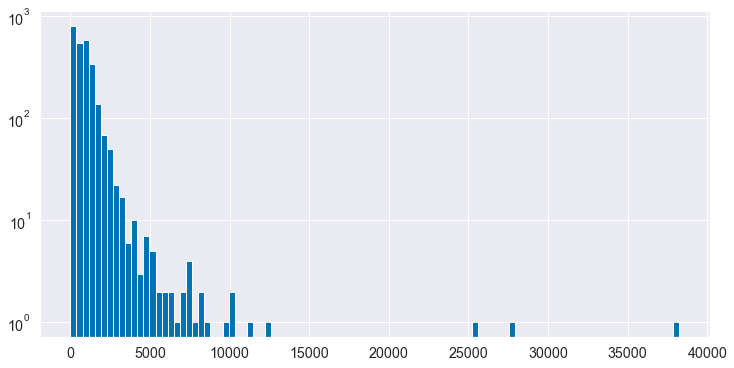

In [8]:
_, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.hist(species_df['length'], bins=100, log=True);

In [9]:
temperatures, mean, std = load_growth_temperatures(engine)

In [42]:
x = sequence_embedding(
    species_df['sequence'].values, 
    ALPHABET_DNA, 
    dtype='float32',
)
y = species_df['growth_tmp'].values
y_norm = normalize(y, mean, std)

In [43]:
bin_to_weights, bins = compute_inverse_probability_weights(temperatures)
sample_weights = assign_weight_to_batch_values(
    y, 
    bin_to_weights, 
    bins,
    dtype='float32',
)

In [12]:
compile_regression_model(
    model, 
    learning_rate=1e-4,
    weighted_metrics=[
        DenormalizedMAE(
            mean=mean, 
            std=std,
            dtype='float32',
        )
    ],
)
model.load_weights(model_path)

In [13]:
min_ = int(np.floor(np.min(temperatures)))
max_ = int(np.ceil(np.max(temperatures)))
temp_range = list(range(-10, 110, 3))
temp_range_norm = normalize(temp_range, mean, std)

In [22]:
%%time
total_pmass = []
for i in range(len(x)):
    if (i+1) % 100 == 0:
        print(f'{i+1} / {len(x)}')
    pmass = []
    dist = model(x[i:i+1])
    for t in temp_range_norm:
        pmass.append(dist.prob(t).numpy()[0])
    total_pmass.append(pmass)

100 / 2641
200 / 2641
300 / 2641
400 / 2641
500 / 2641
600 / 2641
700 / 2641
800 / 2641
900 / 2641
1000 / 2641
1100 / 2641
1200 / 2641
1300 / 2641
1400 / 2641
1500 / 2641
1600 / 2641
1700 / 2641
1800 / 2641
1900 / 2641
2000 / 2641
2100 / 2641
2200 / 2641
2300 / 2641
2400 / 2641
2500 / 2641
2600 / 2641
CPU times: user 4min 12s, sys: 28.6 s, total: 4min 41s
Wall time: 1min 42s


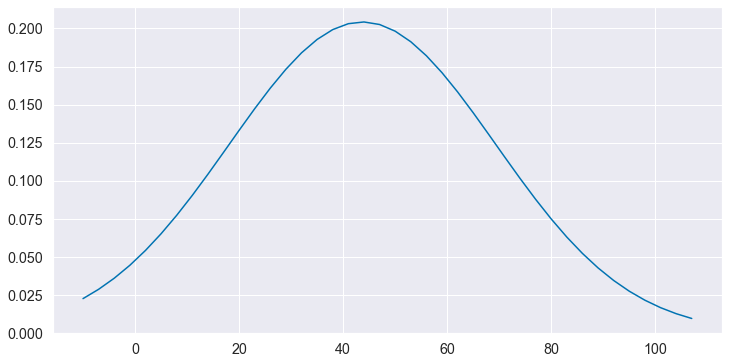

In [34]:
p = np.mean(total_pmass, axis=0)

_, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(temp_range, p);